In [15]:
%matplotlib inline
%load_ext zipline
%load_ext autoreload
%autoreload 2

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

import plotly
import cufflinks

# (*) To communicate with Plotly's server, sign in with credentials file
import chart_studio.plotly as py

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

from zipline import run_algorithm
from zipline.utils.run_algo import load_extensions

from investment_analysis.markowitz import strategy
from investment_analysis.markowitz import computation
from investment_analysis.zipline_ingester import VANGUARD_UNIVERSE

import pandas_datareader.data as web

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

cufflinks.go_offline() #will make cufflinks offline
cufflinks.set_config_file(offline=False, world_readable=True)

# Turn off progress printing 
solvers.options['show_progress'] = False
os.environ['ZIPLINE_ROOT'] = '/home/rory/.zipline'

In [3]:
VANGUARD_UNIVERSE

{'VUKE.L': 1,
 'VMID.L': 2,
 'VUSA.L': 3,
 'VERX.L': 4,
 'VGER.L': 6,
 'VWRL.L': 8,
 'VHYL.L': 9,
 'VEVE.L': 10,
 'VJPN.L': 11,
 'VAPX.L': 12,
 'VNRT.L': 13,
 'VFEM.L': 14,
 'VECP.L': 15,
 'VETY.L': 16,
 'VAGP.L': 17,
 'VGOV.L': 18,
 'VUCP.L': 19,
 'VUTY.L': 20,
 'VEMT.L': 21}

In [5]:
# get ohlc's
vger = yf.Ticker('VGER.L').history('5y')
vuke = yf.Ticker('VUKE.L').history('5y')
vmid = yf.Ticker('VMID.L').history('5y')
vusa = yf.Ticker('VUSA.L').history('5y')
vjpn = yf.Ticker('VJPN.L').history('5y')
vwrl = yf.Ticker('VWRL.L').history('5y')

<AxesSubplot:xlabel='Date'>

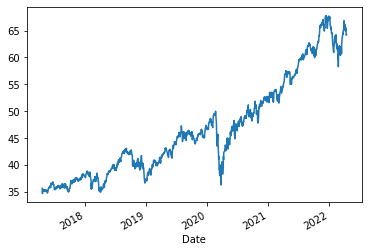

In [14]:
vusa[vusa].Open.plot()

In [10]:
returns = pd.DataFrame(list(map(
        lambda close: close.pct_change().dropna().squeeze(), [
            vger['Close'],
            vuke['Close'],
            vmid['Close'],
            vusa['Close'],
            vjpn['Close'],
            vwrl['Close'],
        ]
    )), columns=['vger', 'vuke', 'vmid', 'vusa', 'vjpn', 'vwrl']).T.dropna()

In [11]:
returns

,Close,Close,Close,Close,Close,Close


In [6]:
weights, _, _ = computation.optimal_portfolio(returns.T)
weights

array([[3.60803565e-06],
       [9.56558889e-05],
       [1.45194065e-06],
       [9.99892853e-01],
       [2.67753341e-06],
       [3.75396535e-06]])

In [17]:
from zipline.algorithm import TradingAlgorithm

def analyze(context: TradingAlgorithm, perf):
    print(context.portfolio)
    
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    bench_mark: pd.Series = context.benchmark_returns.squeeze().dropna()
    bench_mark = context.portfolio.starting_cash*bench_mark.add(1).cumprod()
    perf.portfolio_value.plot(ax=ax1, legend=True)
    bench_mark.plot(ax=ax1, legend=True)
    ax1.set_ylabel('portfolio value in $')
    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    #buys.plot(ax=ax1)
    #sells.plot(ax=ax1)
    ax2.set_ylabel('weights')
    for asset in context.assets:
        perf[asset.symbol].plot(ax=ax2)
    plt.legend(loc=0)
    plt.show()

#analyze(Tr, perf)

In [22]:
sp500 = web.DataReader('SP500', 'fred', start, end).SP500

In [25]:


start = pd.Timestamp('2021-04-18')
end = pd.Timestamp('2022-04-18')

sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()


perf: pd.DataFrame = run_algorithm(
    start=start.tz_localize('UTC'),
    end=end.tz_localize('UTC'),
    initialize=strategy.initialize,
    handle_data=strategy.handle_data,
    benchmark_returns=benchmark_returns,
    analyze=analyze,
    capital_base=27000,
    bundle='yahoo-finance-universe',
    data_frequency='daily'
)
perf.to_csv('./backtest.pickle')

KeyError: Equity(3 [VUSA.L])